In [106]:
# import all the libraries we need
import folium
import requests
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import Key as key

In [2]:
# func to automate the process of getting through the api 
# get the information and immediately convert it into a json file
def get_all_info_brew(url, api_key, start_page=1, page_lim=100): 
    '''takes in a url in the form of a string
       takes in an api_key as a string
       takes optional parameter start_page as an int which defaults to 1
       takes optional parameter page_limit as an int which defaults to 100
       returns a list of jsons files'''
    data = [] 
    p = start_page
    while p <= page_lim:
        url_params = {
                        'key': api_key,
                        "withBreweries" : "Y",
                        "p": p
                    }
        # a list of json files
        data.append(requests.get(url,params=url_params).json())
        p += 1
    return data

In [9]:
url = "https://sandbox-api.brewerydb.com/v2/beers/"
brew_json_data = get_all_info_brew(url, key.key, 1, 200)

[{'currentPage': 2,
  'numberOfPages': 23,
  'totalResults': 1109,
  'data': [{'id': 'hYaduh',
    'name': 'Alt Route - Beer Camp Across America',
    'nameDisplay': 'Alt Route - Beer Camp Across America (2014)',
    'description': 'Brewers are notorious for refusing to take the easy path. Instead, we lead with our hearts and pursue our passions no matter how difficult the road ahead. Alt Route is a tribute to this stubborn spirit that drove us to dodge the status quo and found breweries. Together we chased the siren song of beer with this revamped take on an antique beer style.\r\n\r\nLike us, Victory is one of the few brewers with an allegiance to whole-cone hops. They do extensive work with hop flavor, especially focusing on clever and delicious single-hop beers highlighting the same hop grown in different regions. They too share our roots in home brewing and never lost their passion for working with new beers and styles solely for the joy of making something new.',
    'abv': '6.6'

In [ ]:
# store our raw json data
with open('brew_data_pages_201_to_400_backup.json', 'w') as outfile:
    json.dump(brew_json_pages_data, outfile)

In [11]:
#opens our json file that we saved

with open("brew_data_pages_1_to_200_backup.json") as datajson:
    brew_data =json.load(datajson)

In [22]:
#test if it works
brew_data[0]['data']

[{'id': 'StdoHr',
  'name': '!',
  'nameDisplay': '!',
  'description': 'Imperial Bitter',
  'abv': '8.2',
  'availableId': 3,
  'styleId': 13,
  'isOrganic': 'N',
  'isRetired': 'Y',
  'status': 'verified',
  'statusDisplay': 'Verified',
  'createDate': '2018-05-10 19:07:18',
  'updateDate': '2018-11-02 02:13:07',
  'available': {'id': 3,
   'name': 'Not Available',
   'description': 'Beer is not currently available.'},
  'style': {'id': 13,
   'categoryId': 1,
   'category': {'id': 1,
    'name': 'British Origin Ales',
    'createDate': '2012-03-21 20:06:45'},
   'name': 'Old Ale',
   'shortName': 'Old Ale',
   'description': 'Dark amber to brown in color, old ales are medium to full bodied with a malty sweetness. Hop aroma should be minimal and flavor can vary from none to medium in character intensity. Fruity-ester flavors and aromas can contribute to the character of this ale. Bitterness should be minimal but evident and balanced with malt and/or caramel-like sweetness. Alcohol ty

In [ ]:
# structure of the main json file of properties we might be interested in

{
    "name" : str,
    "id" : str,
    "abv" : float(str),
    "isOrgnanic" : str,
    "isRetired" : str,
    "status" : str,
    "createDate" : str,
    "style" : dict, # look below
    "breweries" : list(dict) # look below category dict section
    
}

# structure of the style dict
{
    "id" : int,
    'category' : dict, # look below
    "name" : str,
    "shortName" : str,
    'ibuMin' : int(str),
    'ibuMax' : int(str),
    'abvMin' : int(str),
    'abvMax' : int(str),
    'srmMin' : int(str),
    'srmMax' : int(str),
    'ogMin' : int(str),
    'fgMin' : int(str),
    'fgMax' : int(str),
    
}
# structure of category dict
{
    "id" : int,
    "name" : str,
}

# brewery structure
{
    "id" : int,
    "name" : str,
    "established" : str,
    "isVerified" : str,
    "locations" : list(dict) # see below
}

# location structure, iterate because of list
{
    "id" : str,
    "name" : str,
    "streetAddress" : str,
    'locality' : str,
    'region' : str,
    'postal' : str,
    "latitude" : float,
    "longitude" : float,
    "locationType" : str,
    "createDate" : str,
}

In [ ]:
# after doing some thinking through and running some samples we decided upon this structure
# what we want the results to be structured as a list of dicts 

[
    {
    "beer_name" : str,
    "beer_id" : str,
    "abv" : float(str),
    "isOrgnanic" : str,
    "isRetired" : str,
    "status" : str,
    "createDate" : str,
    "style_id" : int,
    "style_name" : str,
    "category_id" : int,
    "category_name" : str,
    "style_shortName" : str,
    'style_ibuMin' : int(str),
    'style_ibuMax' : int(str),
    'style_abvMin' : int(str),
    'style_abvMax' : int(str),
    'style_srmMin' : int(str),
    'style_srmMax' : int(str),
    'style_ogMin' : int(str),
    'style_fgMin' : int(str),
    'style_fgMax' : int(str),
    "brewery_id" : int,
    "brewery_name" : str,
    "brewery_established" : str,
    "brewery_isVerified" : str,
    "brewery_locations_id" : str,
    "brewery_locations_name" : str,
    "brewery_locations_map" : [float, float] # [latidude, longitude],
    "brewery_locations_locality" : str
    }
]


In [122]:
# a parser function to clean the data
def parse(data_lst):
    # elements of the style keys list to look for when we parse through style 
    style_lst = ["id", "name", "shortName",'abvMax','srmMin', 'srmMax', "ibuMax", "ibuMin",
                 'ogMin','fgMin','fgMax' ]
    api_dict_list = []
    # read_through each in the data_list
    for index in range(len(data_lst)):
        for api_call in data_lst[index]["data"]:
            api_dict = {}
            api_dict["name"] = api_call["name"]
            if 'abv' in api_call:
                api_dict["abv"] = float(api_call["abv"])
            api_dict["organic?"] = api_call["isOrganic"]
            api_dict["retired?"] = api_call["isRetired"]
            api_dict["status"] = api_call["status"]
            api_dict["createDate"] = api_call["createDate"]
            if "style" in api_call:
                for style in style_lst:
                    if style in api_call["style"]:
                        api_dict[f"s_{style}"] = api_call["style"][style]
                api_dict["category_name"] = api_call["style"]["category"]["name"]
                api_dict["category_id"] = api_call["style"]["category"]["id"]
            brewery = api_call["breweries"][0]
            api_dict[f"brewery_name"] =  brewery["name"]
            api_dict[f"brewery_id"] = brewery["id"]
            if "established" in api_call["breweries"]:
                api_dict[f"established"] = brewery["established"]
            api_dict["brewery_locations_map"] = []
            api_dict["brewery_locations"] = []
            api_dict["brewery_locality"] = ""
            count = 1
            for idx in range(len(brewery["locations"])):
                brew_location = brewery["locations"][idx]
                api_dict["brewery_locations"].append(brew_location["name"])
                if "latitude" in brew_location and "longitude" in brew_location:
                    api_dict["brewery_locations_map"].append([float(brew_location["latitude"]),
                                                             float(brew_location["longitude"])])
                if "locality" in brew_location:
                    api_dict["brewery_locality"]+= f'{count}. {brew_location["locality"]}' + " "
                    count += 1
            api_dict["number_of_locations"] = len(api_dict["brewery_locations"])
            api_dict_list.append(api_dict)
    return api_dict_list
parsed_data = parse(brew_data)

In [123]:
# turn parsed data into a panda dataframe
brewery_df = pd.DataFrame(parsed_data)

In [124]:
# previewing data
brewery_df

abv brewery_id                                   brewery_locality  \
0      8.20     AAxJnJ                                         1. Örebro    
1     11.10     qa1QZU                                    1. Wallingford    
2      6.33     DBkLHq                                       1. Boothbay    
3      7.00     BU4IJP              1. Milwaukee 2. Milwaukee 3. Grafton    
4      5.40     pvE2w5                                         1. Geneva    
5      4.80     FfMi8U                                         1. Denver    
6      4.60     cZDnM8                                       1. La Verne    
7      8.50     FfMi8U                                         1. Denver    
8      5.80     mMnrjZ                                    1. Albuquerque    
9      7.60     H8jawh                                      1. Livermore    
10    10.80     H8jawh                                      1. Livermore    
11     5.40     mMnrjZ                                    1. Albuquerque    
12    10.40     H8jawh                                      1. Livermore    
13     7.50     Xnf2WT                             1. Turlock 2. Turlock    
14     5.60     nkRssU                                       1. Westmont    
15     5.50     Eu8QY2                                        1. Laramie    
16     4.80     E3f430                                     1. Browns Bay    
17     6.60     H8jawh                                      1. Livermore    
18     4.90     mMnrjZ                                    1. Albuquerque    
19      NaN     GmYAZI                                        1. Atlanta    
20     5.00     qa1QZU                                    1. Wallingford    
21     7.00     NwFxny                        1. Vista 2. Vista 3. Nampa    
22     4.70     snQlvg                  1. Bend 2. Bend 3. Bend 4. Boise    
23     6.00     YG37Js                                        1. Yardley    
24      NaN     qyMFUm                                    1. Cocoa Beach    
25     6.50     S3V7kw                                         1. Morrow    
26     4.90     FfMi8U                                         1. Denver    
27     5.80     u99e3l                                       1. Portland    
28     6.70     X38nDm  1. Charlottesville 2. Harrisonburg 3. Richmond...   
29     3.40     TVuR3j                                      1. San Diego    
...     ...        ...                                                ...   
9970    NaN     oMNpgF                                     1. Las Cruces    
9971   7.10     iG2UXJ                                          1. Chino    
9972   6.50     4F7QA9                                     1. Portsmouth    
9973   6.50     fCroxq                                     1. Great Alne    
9974   6.00     vBKH72                                      1. Cape Town    
9975   6.60     1DMpAC                                       1. Woodbury    
9976   6.00     Ls8xET                                     1. Sturbridge    
9977   7.60     E4qt5T                                         1. Denver    
9978   7.00     gZ4Tqd                                      1. Oceanside    
9979   8.00     FR3XyG                                                      
9980   7.70     JKx7GQ                       1. Chapel Hill 2. Pittsboro    
9981   6.90     nHLlnK                              1. Chico 2. Fletcher    
9982   6.00     T69XYv                                    1. Glens Falls    
9983   6.90     V6C0Zh                                          1. Olean    
9984   6.30     brYyt5                                      1. Nashville    
9985   7.00     mCJhuP                                         1. Austin    
9986    NaN     YMxo1d                                     1. Carbondale    
9987   6.90     Y2gEyS                                      1. 1060 Wien    
9988   4.00     WxtiJC                         1. Hood River 2. Portland    
9989    NaN     obAmbB                                 1. Carleton Place    
9990

In [259]:
# generates random html colors for the map markers
def generate_random_html_colors():
    
    hex_digits= "1234567890ABCDEF"
    hex_code = "#"
    for loop in range(6):
        option = np.random.randint(16)
        hex_code += hex_digits[option]
    return hex_code

# creates a map with markers of the location of every brewery
def create_markers_set(dataframe):
    m = folium.Map(location=[39.7246028, -100.8157154], zoom_start=2, prefer_canvas=True,
                  disable_3d=True)
    name = None
    colour = generate_random_html_colors()
    for i in range(10000):
        if dataframe.index[i][0] != name:
            name = dataframe.index[i][0]
            for loc in dataframe.brewery_locations_map[i]:
                marker = folium.CircleMarker(location = loc, radius = 1, color=colour)
                marker.add_to(m)
    return m

In [322]:
# set the index of the original dataframe and save it in another
bdf = brewery_df.set_index(["brewery_name", "name"])
bdf.sort_index(inplace=True)

In [323]:
# sort the reindexed data into a dataframe organized by number of brewery locations
# use this dataframe for the map
loc_bdf = bdf.sort_values("number_of_locations", ascending=False)

In [260]:
# create the map of all th brewery locations
location_map = create_markers_set(loc_bdf)
location_map

In [261]:
# save the map as an html because it is too big to be displayed in jupyter notebook
location_map.save("map_of_brewery.html")

In [324]:
# organize the multiindexed dataframe to convert any entries in the column to numbers if it is possible
bdf = bdf.apply(pd.to_numeric, errors="ignore").sort_index()

In [325]:
# test it out
bdf

abv  \
brewery_name              name                                             
#FREEDOM Craft Brewery    A Toast                                    NaN   
(512) Brewing Company     (512) ALT                                  6.0   
                          (512) Black IPA                            7.5   
                          (512) Bruin (A.K.A. Brown Bear)            7.6   
                          (512) CAB TRIPEL                           9.5   
                          (512) Cascabel Cream Stout                 6.0   
                          (512) Export Lager                         5.3   
                          (512) FIVE                                10.1   
                          (512) FOUR                                 7.5   
                          (512) IPA                                  7.0   
                          (512) ONE                                  8.0   
                          (512) Pale                                 6.0   
                          (512) Peach Sour                           6.2   
                          (512) SIX                                  7.5   
                          (512) Stingo                               7.5   
                          (512) THREE                                9.5   
                          (512) THREE (Cabernet Barrel Aged)         9.5   
                          (512) TWO                                  9.0   
                          (512) Whiskey Barrel Double Pecan Porter   9.5   
                          (512) White IPA                            5.3   
                          (512) Wild Bear                            8.5   
                          (512) Wit                                  5.1   
+351 Cerveja              351 Cerveja Pale Ale                       5.0   
10 Barrel Brewing Company "Mike Saw a Sasquatch" Session Ale         4.7   
                          10 Barrel OG. Wheat IPA                    6.5   
                          16 Barrels                                10.0   
                          2                                          7.5   
                          4                                          8.0   
                          86'd                                       6.5   
                          Allure                                     4.6   
...                                                                  ...   
belleville brewing        Balham Black                               4.6   
                          Battersea Brownstone                       4.8   
pFriem Family Brewers     Belgian Christmas Ale                      8.0   
                          Belgian Stout                             11.0   
                          Belgian Strong Blonde                      7.5   
                          Belgian Strong Dark                       10.0   
vyturio Alaus Darykla     1784 Anniversary Beer                      5.4   
                          Baltas Alus                                5.2   
À la Fût                  À La Belge Triple                          9.4   
Åbro Bryggeri             Åbro Original                              NaN   
Æblerov                   Alkmene                                    5.9   
                          Ananas                                     5.5   
                          Benene På Nakken                           5.9   
                          Både & #2                                  5.9   
                          Både& #1                                   5.9   
                          Både& #3                                   5.9   
Ægir Bryggeri             Altbier                                    4.7   
Überbrew                  ...Floor                                   6.6   
                          Alpha Force IPA                            7.7   
                          Alpha Force Tactical IPA                   7.8   
                          Alt 0220       

In [314]:
# get an overview of the data
bdf.describe()

abv   category_id  number_of_locations     s_abvMax  \
count  8663.000000  10000.000000         10000.000000  9071.000000   
mean      7.001980      4.922700             1.613600     8.210964   
std       6.509305      3.288648             4.247882     4.148798   
min       0.050000      1.000000             1.000000     2.900000   
25%       5.200000      3.000000             1.000000     5.600000   
50%       6.430000      3.000000             1.000000     7.500000   
75%       8.100000      7.000000             1.000000    10.000000   
max     573.000000     14.000000           125.000000    33.000000   

           s_fgMax      s_fgMin     s_ibuMax     s_ibuMin          s_id  \
count  9000.000000  9000.000000  8838.000000  8477.000000  10000.000000   
mean      1.018899     1.010066    50.186241    29.030081     60.582100   
std       0.006423     0.004994    25.210858    16.666054     41.671337   
min       1.004000     0.992000     6.000000     3.000000      1.000000   
25%       1.014000     1.006000    30.000000    18.000000     30.000000   
50%       1.018000     1.010000    42.000000    25.000000     43.000000   
75%       1.020000     1.012000    70.000000    45.000000     84.000000   
max       1.040000     1.024000   100.000000    65.000000    173.000000   

           s_ogMin     s_srmMax     s_srmMin  
count  9007.000000  8841.000000  8850.000000  
mean      1.052190    22.524941    10.898531  
std       0.015679    19.830061    11.358821  
min       1.008000     2.000000     1.000000  
25%       1.044000    12.000000     4.000000  
50%       1.048000    14.000000     6.000000  
75%       1.060000    30.000000    11.000000  
max       1.090000   100.000000    40.000000

In [300]:
bdf_names_count = pd.DataFrame(bdf.reset_index().groupby("brewery_name").count()["name"]).sort_values("name", ascending=False)



In [301]:
bdf_names_count

name
brewery_name                               
Mikkeller                               102
Imperial Oak Brewing                     77
Sierra Nevada Brewing Co.                74
Begyle Brewing                           54
EPIC Brewing Company                     48
Artisan's Brewery & Italian Grill        45
Three Floyds Brewing Company             44
Adnams Brewery                           37
Stone Brewing                            35
Harpoon Brewery                          34
Cigar City Brewing                       32
Great Lakes Brewing Company              32
Bell's Brewery                           31
The Bruery                               31
BrewDog                                  29
Nowhere In Particular Brewing Company    29
Southern Tier Brewing Company            25
Dogfish Head Craft Brewery               24
Amstel Brewery                           22
Hangar 24 Craft Brewery                  22
Goose Island Beer Company                22
Alaskan Brewing Co.                      22
B. Nektar Meadery                        22
(512) Brewing Company                    21
Rhinegeist                               21
Greenbush Brewing Co                     21
Deschutes Brewery                        21
Midnight Sun Brewing Company             21
Privatbrauerei Bischoff                  20
Short's Brewing Company                  20
...                                     ...
Hoof Hearted Brewing                      1
Honor Brewing Company                     1
Honey Gardens Apiaries                    1
Honest Weight Artisan Beer                1
Holy Mountain Brewing Company             1
Holler Brewing Co.                        1
Hohmanns Brauhaus Fulda                   1
Hohmanns Brauhaus                         1
Hogshead Brewery                          1
Hogs Back Brewery                         1
Hofbräuhaus Traunstein                    1
HoReCare                                  1
Historic Brewing Company                  1
Hirschbräu                                1
Hexagon Brewing Co                        1
Himburgs Braukunstkeller                  1
Hilton Head Brewing Co                    1
Hilliard's Beer                           1
Hijos De Rivera, S.A.                     1
Highland Park Brewery                     1
High Point Brewing Co, Inc.               1
High Plains Brewing                       1
High Park Brewery                         1
High Noon Saloon & Brewery                1
High Branch Brewing                       1
High & Mighty Beer Company                1
Hidden Legend Winery                      1
HiJinx Brewing Co.                        1
Heyday Beer Co.                           1
Indian Joe Brewing, Inc.                  1

[3493 rows x 1 columns]

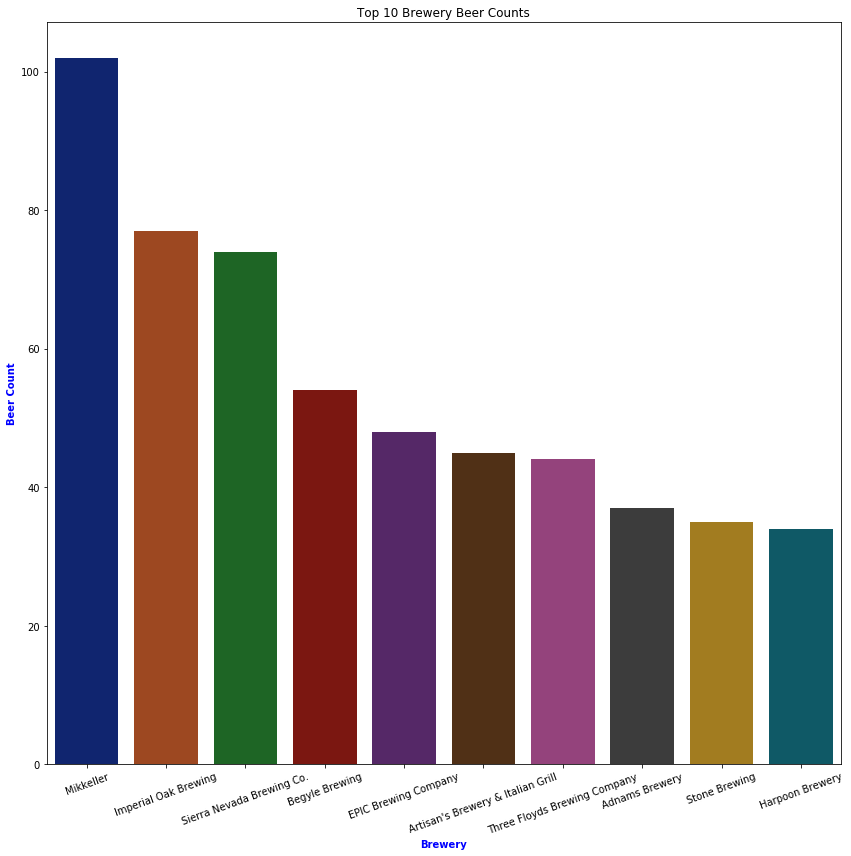

In [365]:
# create a bar plot that shows the 10 breweries with the highest number of beer

fig = plt.figure(figsize=(12, 12)) # create a figure thats 12 x 12 to hold the bar plot

# creates barplot in seaborn using the first 10 index and counts from our datafram
sns.barplot(x =list(bdf_names_count.index[:10]),y=bdf_names_count[:10]["name"], palette='dark') 

# makes the plot presentable by setting the title and x and y axis
plt.title("Top 10 Brewery Beer Counts")
plt.xticks(rotation=20)
plt.xlabel("Brewery", fontweight="bold", color="blue")
plt.ylabel("Beer Count", fontweight="bold", color="blue")
plt.tight_layout()

# uncomment to save file
# plt.savefig("beer_count_by_brewer.png")

In [373]:
# get a dataframe with the counts of the properties for each beers style
bdf_with_counts = bdf.groupby("s_name").count().sort_values(by="brewery_id", ascending=False).brewery_id


s_name
American-Style India Pale Ale                                 883
American-Style Pale Ale                                       531
American-Style Amber/Red Ale                                  434
Imperial or Double India Pale Ale                             420
Specialty Beer                                                332
American-Style Imperial Stout                                 331
French & Belgian-Style Saison                                 300
Golden or Blonde Ale                                          267
American-Style Brown Ale                                      235
American-Style Barley Wine Ale                                204
American-Style Stout                                          178
Berliner-Style Weisse (Wheat)                                 169
Belgian-Style Tripel                                          163
Belgian-Style White (or Wit) / Belgian-Style Wheat            157
Belgian-Style Pale Ale                                        156
Ame

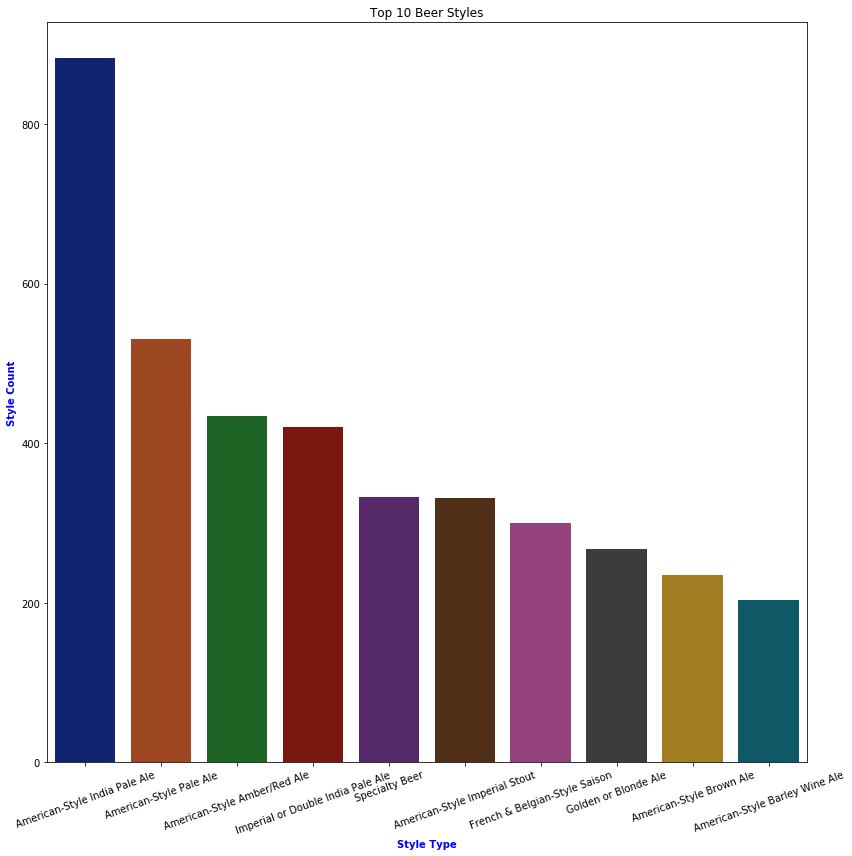

In [374]:
fig = plt.figure(figsize=(12, 12))
sns.barplot(x =list(bdf_with_counts.index[:10]),y=bdf_with_counts[:10], palette='dark')
plt.title("Top 10 Beer Styles")
plt.xticks(rotation=20)

plt.xlabel("Style Type", fontweight="bold", color="blue")
plt.ylabel("Style Count", fontweight="bold", color="blue")
plt.tight_layout()
# plt.savefig("popular_beer_styles")

In [379]:
def sort_by_style_and_prop(dataframe, style_name, prop):
    sorted_df = dataframe[dataframe["s_name"] == style_name].sort_values(prop)
    sorted_df = pd.DataFrame(sorted_df[prop])
    sorted_df[pd.notna(sorted_df[prop])]
    return sorted_df

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tup

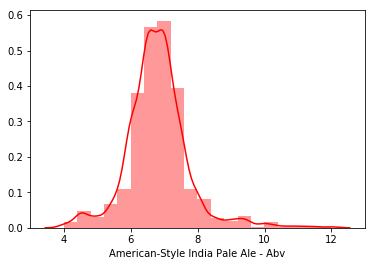

In [380]:
sns.distplot(sort_by_style_and_prop(bdf, "American-Style India Pale Ale", 'abv'), bins=20, axlabel="American-Style India Pale Ale - Abv", color="red" )

# plt.savefig("American_Style_IPA_abv.png")


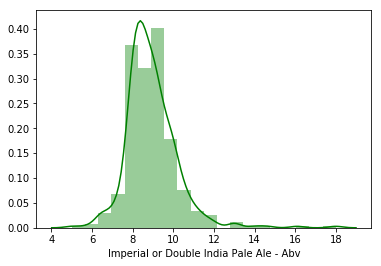

In [381]:
sns.distplot(sort_by_style_and_prop(bdf, "Imperial or Double India Pale Ale", 'abv'), bins=20, axlabel="Imperial or Double India Pale Ale - Abv", color="green" )

# plt.savefig("Imperial_or_Double_India_Pale_Ale_abv.png")


In [388]:
# overview of the Imperial or Double India Pale Ale's abvs
sort_by_style_and_prop(bdf, "Imperial or Double India Pale Ale", 'abv').describe()

abv
count  407.000000
mean     8.931843
std      1.287765
min      5.000000
25%      8.100000
50%      8.700000
75%      9.500000
max     18.000000

In [384]:
# overview of the American-Style India Pale Ale's abvs
sort_by_style_and_prop(bdf, "American-Style India Pale Ale", 'abv').describe()

abv
count  797.00000
mean     6.79813
std      0.94057
min      4.00000
25%      6.30000
50%      6.80000
75%      7.20000
max     11.99000

In [385]:

# search the database by city name and return the beer name and desired property
def search_by_city(city):
    beer_properties = ["abv", "s_name", "organic?", "retired?", "s_ibuMax", "s_abvMax"]
    # list of columns of the dataframe that users can choose from
    print("Properties: abv, s_name, organic?, retired?, s_ibuMax, s_abvMax")
    # input the property
    prop = input("Which property do you want to search by?\n")
    if prop in beer_properties:
        bdf = brewery_df.dropna()
        bdf = bdf[bdf["brewery_locality"].str.contains(city)].sort_values(prop, ascending=False)
        bdf = bdf.set_index(["brewery_name", "name"])
        bdf = bdf[["brewery_locality", prop]]
        return bdf 
    else:
        return "Sorry! That is not a property we have in our dataframe"

In [389]:
# a test of the search_by_city function
search_by_city("Chicago")

Properties: abv, s_name, organic?, retired?, s_ibuMax, s_abvMax
Which property do you want to search by?
abv


brewery_locality  \
brewery_name                     name                                                                                               
Goose Island Beer Company        Baudoinia                                                                 1. Chicago 2. Chicago    
                                 Apple Brandy Barrel Aged Bourbon County Stout                             1. Chicago 2. Chicago    
Half Acre Beer Company           Benthic                                                                   1. Chicago 2. Chicago    
Local Option                     American Muscle – New World Double IPA                                               1. Chicago    
Haymarket Pub & Brewery          Acrimonious Port Barrel Aged Imperial Stout                              1. Chicago 2. Bridgman    
Goose Island Beer Company        Big John                                                                  1. Chicago 2. Chicago    
                                 Barrel-Aged Dark Crusader                                                 1. Chicago 2. Chicago    
Revolution Brewing               4th Year Beer                                                             1. Chicago 2. Chicago    
                                 3rd Year Beer                                                             1. Chicago 2. Chicago    
Pipeworks Brewing Company        Bigger Smokey P                                                                      1. Chicago    
Begyle Brewing                   Begyle Barrel Aged Barleywine                                                        1. Chicago    
Revolution Brewing               1ZENUFF                                                                   1. Chicago 2. Chicago    
Haymarket Pub & Brewery          Barrel Aged Imperial Defender                                            1. Chicago 2. Bridgman    
Pipeworks Brewing Company        As You Wish...                                                                       1. Chicago    
Spiteful Brewing                 10-9 Bike Messenger Appreciation IPA                                                 1. Chicago    
Off Color Brewing                Barrel Aged Dino S'mores (Wild Turkey )                                              1. Chicago    
Lagunitas Brewing Company        Bitter Oats                                                1. Petaluma 2. Chicago 3. Charleston    
Rock Bottom Restaurant & Brewery Barrel Aged Black Hawk Stout                   1. Charlotte 2. Chicago 3. Cincinnati 4. Denve...   
Revolution Brewing               Batch 2000                                                                1. Chicago 2. Chicago    
Off Color Brewing                Barrel Aged Dino S'mores (2yr Willett Rye)                                           1. Chicago    
Pipeworks Brewing Company        Abduction                                                                            1. Chicago    
                                 Abduction Coffee Break                                                               1. Chicago    
Half Acre Beer Company           Big Hugs                                                                  1. Chicago 2. Chicago    
                                 Big Hugs (2017)                                                           1. Chicago 2. Chicago    
                                 Big Hugs                                                                  1. Chicago 2. Chicago    
Lake Effect Brewing Company      Barrel-Aged Imperial Stout                                                           1. Chicago    
Finch Beer Co.                   Altus Gravitas                                                                       1. Chicago    
Half Acre Beer Company           Big Hugs                                                                  1. Chicago 2. Chicago    
Begyle Brewing                   Begyle Barrel Aged Imperial Pajamas                                                  1. Ch